Imports

In [1]:
import math
import numpy as np
import tensorflow
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist, cifar100

In [2]:
from tensorflow.keras.utils import to_categorical

Load CIFAR10 Data

In [3]:
(training_data,training_labels),(testing_data,testing_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 5s 0us/step


In [4]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Use 25% of data for hyper-parameter tuning

In [5]:
training_data = training_data[:12500,:,:]
training_labels = training_labels[:12500]
testing_data = testing_data[:2500,:,:]
testing_labels = testing_labels[:2500]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(12500, 32, 32, 3) (12500, 1) (2500, 32, 32, 3) (2500, 1)


Pre-processing

In [6]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [7]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

In [8]:
from tensorflow.keras.utils import to_categorical

nclasses = 10

# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

Dividing the training data to get validation set

In [9]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(11250, 32, 32, 3) (1250, 32, 32, 3) (11250, 10) (1250, 10)


Implementation of APNet Architecture

In [10]:
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

class APNet:

    def __init__(self, nclasses=10) -> None:
       
        self.nclasses = nclasses
        self.input_layer = Input(shape=(training_data.shape[1],training_data.shape[2],training_data.shape[3]))

        convolution_1_layer = Conv2D(filters=32, kernel_size=(7,7), strides=2, padding='same', activation='relu')(self.input_layer)
        maxpool_1_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(convolution_1_layer)
        norm_1_layer = BatchNormalization()(maxpool_1_layer)

        convolution_2_layer = Conv2D(filters=64, kernel_size=(11,11), strides=2, padding='same', activation='relu')(norm_1_layer)
        norm_2_layer = BatchNormalization()(convolution_2_layer)
        maxpool_2_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(norm_2_layer)

        convolution_3a_layer = Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same', activation='relu')(maxpool_2_layer)
        convolution_3b_layer = Conv2D(filters=16, kernel_size=(5,5), strides=1, padding='same', activation='relu')(maxpool_2_layer)
        conv_concat = Concatenate(axis=-1,)([convolution_3a_layer,convolution_3b_layer])
        maxpool_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(conv_concat)
        
        fc_layer = Flatten()(maxpool_layer)
        fc_layer = Dense(units=1024, activation='relu')(fc_layer)
        dropout_layer = Dropout(rate=0.6)(fc_layer)

        self.output_layer = Dense(units=nclasses, activation='softmax')(dropout_layer)

        self.model = Model(inputs=self.input_layer, outputs=self.output_layer)
    

In [11]:
model_hpt_epoch = APNet(nclasses=nclasses).model
model_hpt_epoch.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.01,
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_hpt_epoch.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   4736        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 32)     0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 32)    128         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [12]:
batch_size = 256

In [13]:
train_hist = []

In [14]:
hist = model_hpt_epoch.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=50, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/50
44/44 [==============================] - 9s 26ms/step - loss: 1.9904 - accuracy: 0.2582 - val_loss: 2.2431 - val_accuracy: 0.1920
Epoch 2/50
44/44 [==============================] - 0s 10ms/step - loss: 1.5620 - accuracy: 0.4218 - val_loss: 2.1361 - val_accuracy: 0.3360
Epoch 3/50
44/44 [==============================] - 1s 12ms/step - loss: 1.3732 - accuracy: 0.4964 - val_loss: 1.9633 - val_accuracy: 0.3808
Epoch 4/50
44/44 [==============================] - 0s 11ms/step - loss: 1.2302 - accuracy: 0.5537 - val_loss: 1.7833 - val_accuracy: 0.4392
Epoch 5/50
44/44 [==============================] - 1s 11ms/step - loss: 1.1238 - accuracy: 0.5961 - val_loss: 1.7222 - val_accuracy: 0.3688
Epoch 6/50
44/44 [==============================] - 0s 11ms/step - loss: 0.9968 - accuracy: 0.6427 - val_loss: 1.5146 - val_accuracy: 0.4672
Epoch 7/50
44/44 [==============================] - 0s 11ms/step - loss: 0.9061 - accuracy: 0.6813 - val_loss: 1.4271 - val_accuracy: 0.4952
Epoch 8/50
44

In [15]:
import matplotlib.pyplot as plt

def showLossAccPlots2(train_hist):
    
    training_acc = []
    validate_acc = []
    train_losses = []
    validate_losses = []
    
    for th in train_hist:
        train_losses += th.history['loss']
        validate_losses += th.history['val_loss']
        training_acc += th.history['accuracy']
        validate_acc += th.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(2, 1)

    epochs = range(1, len(training_acc) + 1)

    fig.suptitle('Losses and Accuracies across epochs')

    ax1.plot(epochs, train_losses, 'b', label='Training Loss')
    ax1.plot(epochs, validate_losses, 'r', label='Validation Loss')
    ax1.set_ylabel('Losses')
    ax1.legend()

    ax2.plot(epochs, training_acc, 'b', label='Train accuracy')
    ax2.plot(epochs, validate_acc, 'r', label='Validate accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Accuracies')
    ax2.legend()

    plt.show()


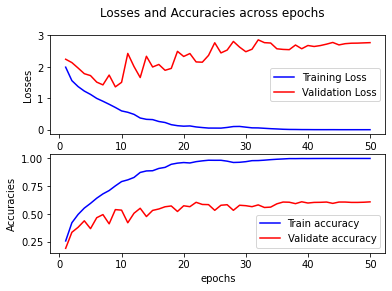

In [16]:
showLossAccPlots2(train_hist)

As we can see, validation accuracy stabilizes at 40 epochs. Hence, we set the number of epochs = 40.

In [17]:
epochs = 40

In [18]:
learning_rates = [0.001, 0.01, 0.1]

model_hpt_lr0 = APNet(nclasses=nclasses).model
model_hpt_lr0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[0],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [19]:
train_hist = []
hist = model_hpt_lr0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
44/44 [==============================] - 1s 18ms/step - loss: 2.2752 - accuracy: 0.1540 - val_loss: 2.2967 - val_accuracy: 0.1112
Epoch 2/40
44/44 [==============================] - 0s 10ms/step - loss: 2.0599 - accuracy: 0.2533 - val_loss: 2.2865 - val_accuracy: 0.1576
Epoch 3/40
44/44 [==============================] - 0s 11ms/step - loss: 1.8805 - accuracy: 0.3080 - val_loss: 2.2719 - val_accuracy: 0.2064
Epoch 4/40
44/44 [==============================] - 0s 11ms/step - loss: 1.7367 - accuracy: 0.3565 - val_loss: 2.2356 - val_accuracy: 0.2440
Epoch 5/40
44/44 [==============================] - 0s 11ms/step - loss: 1.6292 - accuracy: 0.3929 - val_loss: 2.1726 - val_accuracy: 0.3888
Epoch 6/40
44/44 [==============================] - 0s 10ms/step - loss: 1.5367 - accuracy: 0.4316 - val_loss: 2.0859 - val_accuracy: 0.4200
Epoch 7/40
44/44 [==============================] - 0s 11ms/step - loss: 1.4412 - accuracy: 0.4663 - val_loss: 1.9617 - val_accuracy: 0.4296
Epoch 8/40
44

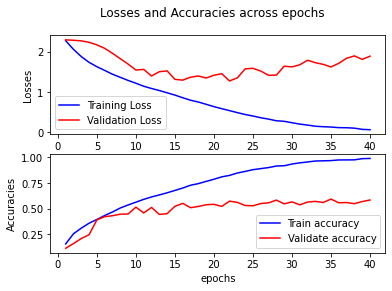

In [20]:
showLossAccPlots2(train_hist)

In [21]:
model_hpt_lr1 = APNet(nclasses=nclasses).model
model_hpt_lr1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[1],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [37]:
train_hist = []
hist = model_hpt_lr1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
44/44 [==============================] - 1s 18ms/step - loss: 2.0399 - accuracy: 0.2407 - val_loss: 2.2582 - val_accuracy: 0.2456
Epoch 2/40
44/44 [==============================] - 0s 10ms/step - loss: 1.5932 - accuracy: 0.4110 - val_loss: 2.1555 - val_accuracy: 0.3376
Epoch 3/40
44/44 [==============================] - 0s 11ms/step - loss: 1.3833 - accuracy: 0.4922 - val_loss: 2.0787 - val_accuracy: 0.2208
Epoch 4/40
44/44 [==============================] - 0s 10ms/step - loss: 1.2473 - accuracy: 0.5458 - val_loss: 1.8089 - val_accuracy: 0.4072
Epoch 5/40
44/44 [==============================] - 0s 10ms/step - loss: 1.1185 - accuracy: 0.5946 - val_loss: 1.7303 - val_accuracy: 0.3896
Epoch 6/40
44/44 [==============================] - 0s 11ms/step - loss: 1.0122 - accuracy: 0.6399 - val_loss: 1.4282 - val_accuracy: 0.5392
Epoch 7/40
44/44 [==============================] - 0s 10ms/step - loss: 0.8964 - accuracy: 0.6767 - val_loss: 1.4600 - val_accuracy: 0.4800
Epoch 8/40
44

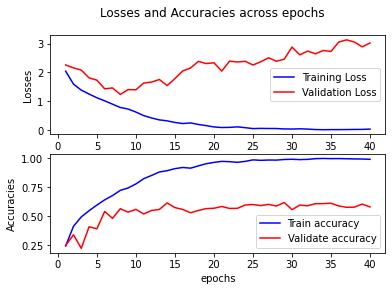

In [38]:
showLossAccPlots2(train_hist)

In [39]:
model_hpt_lr2 = APNet(nclasses=nclasses).model
model_hpt_lr2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[2],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [40]:
train_hist = []
hist = model_hpt_lr2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
44/44 [==============================] - 1s 18ms/step - loss: 1.9232 - accuracy: 0.2842 - val_loss: 2.0513 - val_accuracy: 0.2192
Epoch 2/40
44/44 [==============================] - 0s 10ms/step - loss: 1.6470 - accuracy: 0.3958 - val_loss: 2.0911 - val_accuracy: 0.2448
Epoch 3/40
44/44 [==============================] - 0s 11ms/step - loss: 1.5007 - accuracy: 0.4598 - val_loss: 2.1624 - val_accuracy: 0.3256
Epoch 4/40
44/44 [==============================] - 0s 10ms/step - loss: 1.3511 - accuracy: 0.5143 - val_loss: 2.5786 - val_accuracy: 0.2888
Epoch 5/40
44/44 [==============================] - 0s 10ms/step - loss: 1.2446 - accuracy: 0.5545 - val_loss: 1.5164 - val_accuracy: 0.4552
Epoch 6/40
44/44 [==============================] - 0s 10ms/step - loss: 1.1382 - accuracy: 0.5959 - val_loss: 1.3817 - val_accuracy: 0.5384
Epoch 7/40
44/44 [==============================] - 0s 10ms/step - loss: 1.0504 - accuracy: 0.6272 - val_loss: 1.4742 - val_accuracy: 0.5128
Epoch 8/40
44

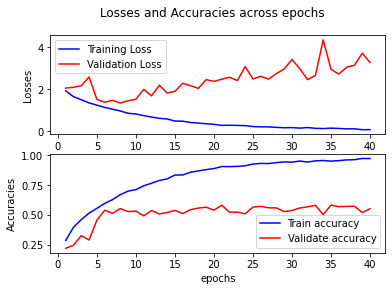

In [41]:
showLossAccPlots2(train_hist)

We can see that lr=0.001 yields slower rise in performance on the validation set, eventually matching the rest. Also, it does not lead the model to overfit. Hence we set learning rate = 0.001

In [27]:
learning_rate = 0.001

In [42]:
momentums = [0.9, 0.75, 0.6]

model_hpt_mt0 = APNet(nclasses).model
model_hpt_mt0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[0]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [43]:
train_hist = []
hist = model_hpt_mt0.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
44/44 [==============================] - 1s 17ms/step - loss: 2.2734 - accuracy: 0.1526 - val_loss: 2.2965 - val_accuracy: 0.1216
Epoch 2/40
44/44 [==============================] - 0s 10ms/step - loss: 2.0619 - accuracy: 0.2473 - val_loss: 2.2878 - val_accuracy: 0.1984
Epoch 3/40
44/44 [==============================] - 0s 10ms/step - loss: 1.9019 - accuracy: 0.2993 - val_loss: 2.2736 - val_accuracy: 0.2264
Epoch 4/40
44/44 [==============================] - 0s 10ms/step - loss: 1.7790 - accuracy: 0.3360 - val_loss: 2.2366 - val_accuracy: 0.3008
Epoch 5/40
44/44 [==============================] - 0s 11ms/step - loss: 1.6674 - accuracy: 0.3829 - val_loss: 2.1750 - val_accuracy: 0.3152
Epoch 6/40
44/44 [==============================] - 0s 10ms/step - loss: 1.5669 - accuracy: 0.4319 - val_loss: 2.0800 - val_accuracy: 0.4160
Epoch 7/40
44/44 [==============================] - 0s 10ms/step - loss: 1.4880 - accuracy: 0.4571 - val_loss: 1.9577 - val_accuracy: 0.4472
Epoch 8/40
44

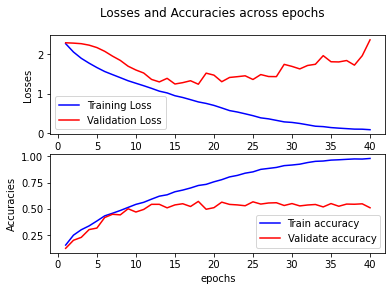

In [44]:
showLossAccPlots2(train_hist)

In [45]:
model_hpt_mt1 = APNet(nclasses).model
model_hpt_mt1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[1]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [46]:
train_hist = []
hist = model_hpt_mt1.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
44/44 [==============================] - 1s 14ms/step - loss: 2.3275 - accuracy: 0.1346 - val_loss: 2.2999 - val_accuracy: 0.1656
Epoch 2/40
44/44 [==============================] - 0s 11ms/step - loss: 2.1806 - accuracy: 0.1971 - val_loss: 2.2959 - val_accuracy: 0.2088
Epoch 3/40
44/44 [==============================] - 0s 10ms/step - loss: 2.0679 - accuracy: 0.2424 - val_loss: 2.2878 - val_accuracy: 0.2264
Epoch 4/40
44/44 [==============================] - 0s 10ms/step - loss: 1.9639 - accuracy: 0.2745 - val_loss: 2.2690 - val_accuracy: 0.2576
Epoch 5/40
44/44 [==============================] - 0s 10ms/step - loss: 1.8730 - accuracy: 0.3039 - val_loss: 2.2317 - val_accuracy: 0.3184
Epoch 6/40
44/44 [==============================] - 0s 11ms/step - loss: 1.8071 - accuracy: 0.3287 - val_loss: 2.1749 - val_accuracy: 0.3728
Epoch 7/40
44/44 [==============================] - 0s 10ms/step - loss: 1.7466 - accuracy: 0.3532 - val_loss: 2.0881 - val_accuracy: 0.3992
Epoch 8/40
44

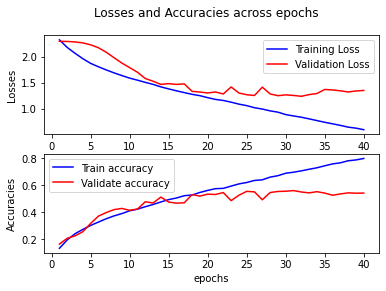

In [47]:
showLossAccPlots2(train_hist)

In [48]:
model_hpt_mt2 = APNet(nclasses).model
model_hpt_mt2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[2]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [49]:
train_hist = []
hist = model_hpt_mt2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
44/44 [==============================] - 1s 15ms/step - loss: 2.3361 - accuracy: 0.1199 - val_loss: 2.3006 - val_accuracy: 0.1240
Epoch 2/40
44/44 [==============================] - 0s 11ms/step - loss: 2.2415 - accuracy: 0.1637 - val_loss: 2.2968 - val_accuracy: 0.1640
Epoch 3/40
44/44 [==============================] - 0s 11ms/step - loss: 2.1750 - accuracy: 0.1969 - val_loss: 2.2911 - val_accuracy: 0.1752
Epoch 4/40
44/44 [==============================] - 1s 12ms/step - loss: 2.1091 - accuracy: 0.2191 - val_loss: 2.2765 - val_accuracy: 0.2040
Epoch 5/40
44/44 [==============================] - 0s 10ms/step - loss: 2.0570 - accuracy: 0.2380 - val_loss: 2.2534 - val_accuracy: 0.2360
Epoch 6/40
44/44 [==============================] - 1s 12ms/step - loss: 1.9973 - accuracy: 0.2605 - val_loss: 2.2084 - val_accuracy: 0.2768
Epoch 7/40
44/44 [==============================] - 0s 10ms/step - loss: 1.9487 - accuracy: 0.2692 - val_loss: 2.1484 - val_accuracy: 0.3072
Epoch 8/40
44

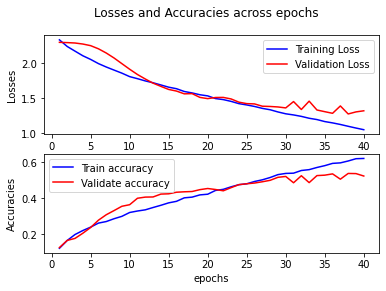

In [50]:
showLossAccPlots2(train_hist)

Here we see that the validation accuracy is similar for all momentum values, but the validation losses appear to be least for the value of 0.75 and so we will set it accordingly.

In [51]:
momentum = 0.75

MNIST Dataset

In [52]:
(training_data,training_labels),(testing_data,testing_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [53]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
training_labels = training_labels[:, np.newaxis]
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
testing_labels = testing_labels[:, np.newaxis]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


In [54]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [55]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [56]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [57]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [58]:
model_apnet_mnist = APNet().model
model_apnet_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_apnet_mnist.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 32)   1600        ['input_12[0][0]']               
                                                                                                  
 max_pooling2d_33 (MaxPooling2D  (None, 7, 7, 32)    0           ['conv2d_44[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_22 (BatchN  (None, 7, 7, 32)    128         ['max_pooling2d_33[0][0]']

In [59]:
train_hist = []
hist = model_apnet_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
211/211 [==============================] - 3s 10ms/step - loss: 1.4627 - accuracy: 0.5247 - val_loss: 2.0102 - val_accuracy: 0.8590
Epoch 2/40
211/211 [==============================] - 2s 8ms/step - loss: 0.3472 - accuracy: 0.9105 - val_loss: 0.5479 - val_accuracy: 0.9558
Epoch 3/40
211/211 [==============================] - 2s 8ms/step - loss: 0.1723 - accuracy: 0.9550 - val_loss: 0.1320 - val_accuracy: 0.9707
Epoch 4/40
211/211 [==============================] - 2s 8ms/step - loss: 0.1203 - accuracy: 0.9668 - val_loss: 0.0867 - val_accuracy: 0.9777
Epoch 5/40
211/211 [==============================] - 2s 8ms/step - loss: 0.0922 - accuracy: 0.9746 - val_loss: 0.0704 - val_accuracy: 0.9807
Epoch 6/40
211/211 [==============================] - 2s 8ms/step - loss: 0.0776 - accuracy: 0.9790 - val_loss: 0.0632 - val_accuracy: 0.9815
Epoch 7/40
211/211 [==============================] - 2s 8ms/step - loss: 0.0655 - accuracy: 0.9819 - val_loss: 0.0580 - val_accuracy: 0.9835
Epoch

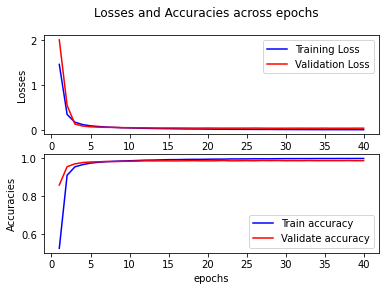

In [60]:
showLossAccPlots2(train_hist)

In [61]:
# Save the model
model_apnet_mnist.save('APNetMnist.h5')

In [62]:
model_apnet_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

40/40 [==============================] - 0s 5ms/step - loss: 0.0305 - accuracy: 0.9909


[0.03046390414237976, 0.9908999800682068]

Fashion-MNIST Dataset

In [63]:
(training_data,training_labels),(testing_data,testing_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [64]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [65]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [66]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [67]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [68]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [69]:
model_apnet_fashion_mnist = APNet().model
model_apnet_fashion_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_apnet_fashion_mnist.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_48 (Conv2D)             (None, 14, 14, 32)   1600        ['input_13[0][0]']               
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 7, 7, 32)    0           ['conv2d_48[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 7, 7, 32)    128         ['max_pooling2d_36[0][0]']

In [70]:
train_hist = []
hist = model_apnet_fashion_mnist.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
211/211 [==============================] - 3s 10ms/step - loss: 1.3212 - accuracy: 0.5452 - val_loss: 2.0389 - val_accuracy: 0.7250
Epoch 2/40
211/211 [==============================] - 2s 8ms/step - loss: 0.6366 - accuracy: 0.7731 - val_loss: 0.9536 - val_accuracy: 0.8162
Epoch 3/40
211/211 [==============================] - 2s 8ms/step - loss: 0.4979 - accuracy: 0.8214 - val_loss: 0.4509 - val_accuracy: 0.8575
Epoch 4/40
211/211 [==============================] - 2s 9ms/step - loss: 0.4282 - accuracy: 0.8487 - val_loss: 0.3792 - val_accuracy: 0.8682
Epoch 5/40
211/211 [==============================] - 2s 8ms/step - loss: 0.3847 - accuracy: 0.8634 - val_loss: 0.3378 - val_accuracy: 0.8798
Epoch 6/40
211/211 [==============================] - 2s 8ms/step - loss: 0.3561 - accuracy: 0.8746 - val_loss: 0.3234 - val_accuracy: 0.8835
Epoch 7/40
211/211 [==============================] - 2s 8ms/step - loss: 0.3291 - accuracy: 0.8843 - val_loss: 0.3106 - val_accuracy: 0.8862
Epoch

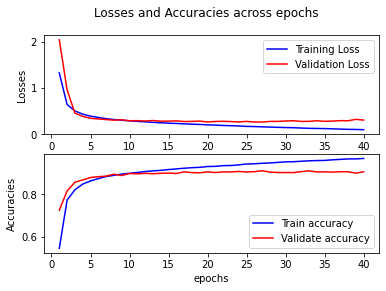

In [71]:
showLossAccPlots2(train_hist)

In [72]:
# Save the model
model_apnet_fashion_mnist.save('APNetFashionMnist.h5')

In [73]:
model_apnet_fashion_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

40/40 [==============================] - 0s 4ms/step - loss: 0.3412 - accuracy: 0.8939


[0.34121572971343994, 0.8938999772071838]

CIFAR-100 Dataset

In [74]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 2s 0us/step


In [75]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [76]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [77]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [78]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [79]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (45000, 100) (5000, 100)


In [80]:
model_apnet_cifar100 = APNet(nclasses=nclasses).model
model_apnet_cifar100.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_apnet_cifar100.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_52 (Conv2D)             (None, 16, 16, 32)   4736        ['input_14[0][0]']               
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 8, 8, 32)    0           ['conv2d_52[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_26 (BatchN  (None, 8, 8, 32)    128         ['max_pooling2d_39[0][0]']

In [81]:
train_hist = []
hist = model_apnet_cifar100.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/40
176/176 [==============================] - 3s 13ms/step - loss: 4.6182 - accuracy: 0.0148 - val_loss: 4.5993 - val_accuracy: 0.0220
Epoch 2/40
176/176 [==============================] - 2s 10ms/step - loss: 4.5381 - accuracy: 0.0246 - val_loss: 4.5500 - val_accuracy: 0.0448
Epoch 3/40
176/176 [==============================] - 2s 10ms/step - loss: 4.4745 - accuracy: 0.0336 - val_loss: 4.4324 - val_accuracy: 0.0544
Epoch 4/40
176/176 [==============================] - 2s 10ms/step - loss: 4.4012 - accuracy: 0.0417 - val_loss: 4.3173 - val_accuracy: 0.0618
Epoch 5/40
176/176 [==============================] - 2s 10ms/step - loss: 4.3317 - accuracy: 0.0496 - val_loss: 4.2253 - val_accuracy: 0.0700
Epoch 6/40
176/176 [==============================] - 2s 10ms/step - loss: 4.2601 - accuracy: 0.0562 - val_loss: 4.1433 - val_accuracy: 0.0818
Epoch 7/40
176/176 [==============================] - 2s 10ms/step - loss: 4.1926 - accuracy: 0.0678 - val_loss: 4.0721 - val_accuracy: 0.0914

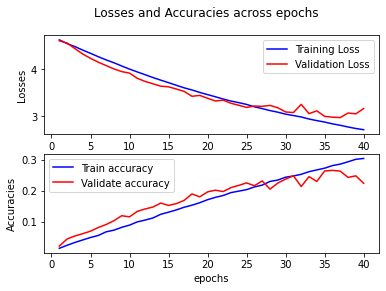

In [82]:
showLossAccPlots2(train_hist)

In [83]:
# Save the model
model_apnet_cifar100.save('APNetCifar100.h5')

In [84]:
model_apnet_cifar100.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 1s 5ms/step - loss: 3.1263 - accuracy: 0.2416


[3.1263091564178467, 0.24160000681877136]

In [90]:
model_apnet_cifar100_v2 = APNet(nclasses=nclasses).model
model_apnet_cifar100_v2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)


In [91]:
train_hist = []
hist = model_apnet_cifar100_v2.fit(x=X_train, y=Y_train, validation_data=(X_validate,Y_validate), epochs=60, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/60
176/176 [==============================] - 3s 12ms/step - loss: 4.6207 - accuracy: 0.0134 - val_loss: 4.6003 - val_accuracy: 0.0188
Epoch 2/60
176/176 [==============================] - 2s 10ms/step - loss: 4.5565 - accuracy: 0.0250 - val_loss: 4.5627 - val_accuracy: 0.0408
Epoch 3/60
176/176 [==============================] - 2s 10ms/step - loss: 4.5073 - accuracy: 0.0321 - val_loss: 4.4707 - val_accuracy: 0.0480
Epoch 4/60
176/176 [==============================] - 2s 10ms/step - loss: 4.4468 - accuracy: 0.0367 - val_loss: 4.3668 - val_accuracy: 0.0506
Epoch 5/60
176/176 [==============================] - 2s 10ms/step - loss: 4.3798 - accuracy: 0.0429 - val_loss: 4.2788 - val_accuracy: 0.0590
Epoch 6/60
176/176 [==============================] - 2s 10ms/step - loss: 4.3141 - accuracy: 0.0498 - val_loss: 4.2119 - val_accuracy: 0.0702
Epoch 7/60
176/176 [==============================] - 2s 10ms/step - loss: 4.2501 - accuracy: 0.0575 - val_loss: 4.1331 - val_accuracy: 0.0882

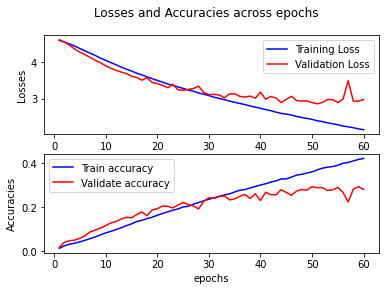

In [92]:
showLossAccPlots2(train_hist)

In [93]:
# Save the model
model_apnet_cifar100_v2.save('APNetCifar100v2.h5')

In [94]:
model_apnet_cifar100_v2.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 1s 4ms/step - loss: 2.9410 - accuracy: 0.2813


[2.9410228729248047, 0.28130000829696655]